In [1]:
from utils import *
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, TimeDistributed
from keras.regularizers import l2
from keras.utils import to_categorical
import tensorflow as tf


Load dataset

In [14]:

X_train, y_train, X_test, y_test = init_data(subject=None)
X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test, verbose=True)
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(X_train, y_train, X_test, y_test)

Training data shape: (8460, 22, 250) Training target shape: (8460,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)


In [12]:
tf.config.list_physical_devices('GPU')  # if this returns empty enable GPU in collab

[]

vanilla cnn

In [9]:
dropout = 0.5
learning_rate = 1e-3
epochs = 70
weight_decay = 1e-2

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(15,1), padding='same', activation='elu', input_shape=(250,1,22), kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=(15,1), padding='same', activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=128, kernel_size=(15,1), padding='same', activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=256, kernel_size=(15,1), padding='same', activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(100, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='glorot_uniform'))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='glorot_uniform'))

optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

model.summary()





Training data shape: (8460, 22, 250) Training target shape: (8460,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 32)        10592     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 32)        128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 64)         3

C:\Users\18646\anaconda3\envs\ece247\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
results = model.fit(x_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/70
109/109 [==============================] - 6s 50ms/step - loss: 3.3394 - accuracy: 0.3342 - val_loss: 2.5958 - val_accuracy: 0.4487
Epoch 2/70
109/109 [==============================] - 5s 47ms/step - loss: 2.3992 - accuracy: 0.4428 - val_loss: 2.1089 - val_accuracy: 0.4760
Epoch 3/70
109/109 [==============================] - 6s 53ms/step - loss: 1.8721 - accuracy: 0.5263 - val_loss: 1.6877 - val_accuracy: 0.5553
Epoch 4/70
109/109 [==============================] - 5s 48ms/step - loss: 1.5223 - accuracy: 0.5786 - val_loss: 1.4158 - val_accuracy: 0.5680
Epoch 5/70
109/109 [==============================] - 5s 48ms/step - loss: 1.2929 - accuracy: 0.6022 - val_loss: 1.1992 - val_accuracy: 0.6393
Epoch 6/70
109/109 [==============================] - 5s 48ms/step - loss: 1.1171 - accuracy: 0.6454 - val_loss: 1.0030 - val_accuracy: 0.6753
Epoch 7/70
109/109 [==============================] - 6s 51ms/step - loss: 0.9986 - accuracy: 0.6741 - val_loss: 0.9122 - val_accuracy: 0.7100

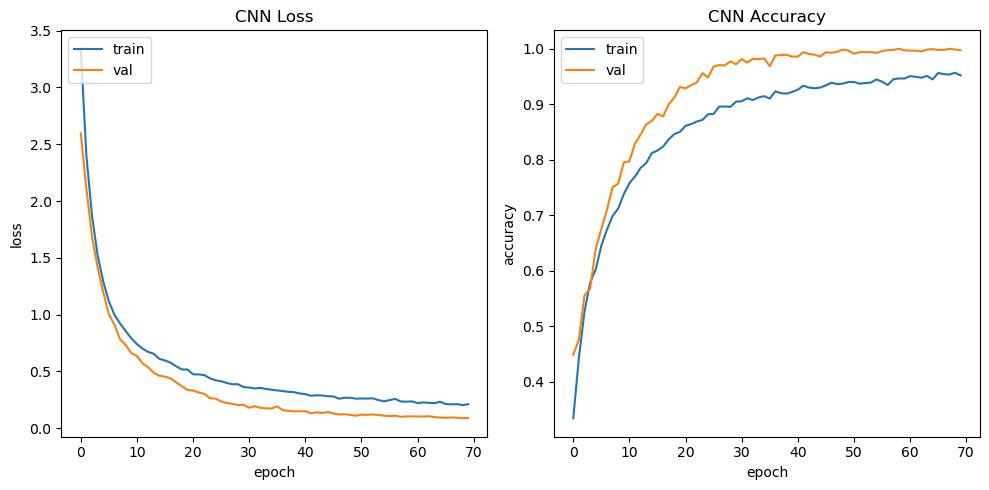

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
## Testing

score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy:{score[1]}')

Test accuracy:0.6930022835731506


(2115, 22, 1000)


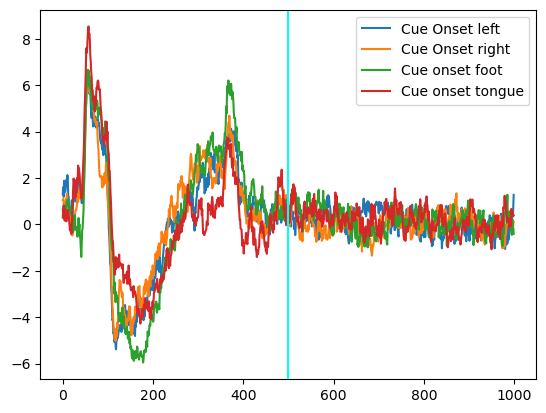

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


In [3]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (1000, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460, 400, 1, 22)
Shape of validation set after dimension reshaping: (1000, 400, 1, 22)

In [5]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 134, 1, 25)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 134, 1, 25)       100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 1, 50)        0

In [20]:
# Model parameters
learning_rate = 1e-2
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime

In [ ]:
!rm -rf ./logs/

In [21]:
# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# # checkpoint saving callback
# save_cb = tf.keras.callbacks.ModelCheckpoint(
#     'models/checkpoint_{epoch:02d}_{val_loss:0.2f}',   # where to save models
#     monitor= 'val_loss',
#     verbose = 0,
#     save_best_only = False,
#     save_weights_only = False,
#     save_freq='epoch'   # saves every epoch
# )

In [22]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True,
             callbacks = [tb_callback, lr_callback])




Epoch 1/100
117/117 [==============================] - 12s 96ms/step - loss: 0.9768 - accuracy: 0.6028 - val_loss: 0.6060 - val_accuracy: 0.7670 - lr: 0.0100
Epoch 2/100
117/117 [==============================] - 11s 95ms/step - loss: 0.9221 - accuracy: 0.6358 - val_loss: 0.7656 - val_accuracy: 0.7110 - lr: 0.0100
Epoch 3/100
117/117 [==============================] - 11s 97ms/step - loss: 0.9112 - accuracy: 0.6382 - val_loss: 0.6261 - val_accuracy: 0.7590 - lr: 0.0100
Epoch 4/100
117/117 [==============================] - 11s 93ms/step - loss: 0.9096 - accuracy: 0.6441 - val_loss: 0.5891 - val_accuracy: 0.7810 - lr: 0.0100
Epoch 5/100
117/117 [==============================] - 11s 93ms/step - loss: 0.8715 - accuracy: 0.6546 - val_loss: 0.5837 - val_accuracy: 0.7890 - lr: 0.0100
Epoch 6/100
117/117 [==============================] - 11s 97ms/step - loss: 0.8824 - accuracy: 0.6504 - val_loss: 0.5717 - val_accuracy: 0.7920 - lr: 0.0100
Epoch 7/100
117/117 [==============================]

In [30]:
# %tensorboard --logdir logs


In [29]:
!kill 90101

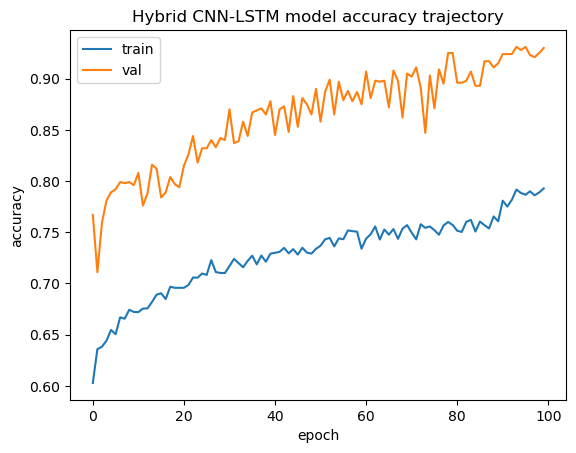

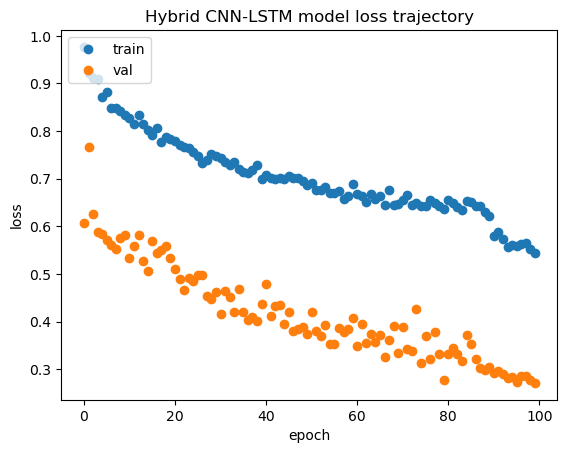

In [31]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7291196584701538


LSTM

In [4]:
timesteps = 400
features = 22

In [48]:
# Define the model
lstm_model = Sequential()

# Adding an LSTM layer
# - units: the dimensionality of the output space
# - input_shape: shape of the input (e.g., (timesteps, features))
lstm_model.add(LSTM(units=25, return_sequences=True, input_shape=(timesteps, features)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=20, return_sequences=True))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=15))
lstm_model.add(Reshape((-1,15)))
lstm_model.add(TimeDistributed(Dense(units=4, activation='softmax')))  # Change the units based on your problem
lstm_model.add(Flatten())
# Compile the model
lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Or another appropriate loss function
              metrics=['accuracy'])

# Summary of the model
lstm_model.summary()


TypeError: 'int' object is not iterable

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[3])
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[3])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[3])

In [7]:
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set after dimension reshaping: (7460, 400, 22)
Shape of validation set after dimension reshaping: (1000, 400, 22)
Shape of test set after dimension reshaping: (443, 400, 22)


In [46]:
epochs = 100


lstm_model_results = lstm_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100


ValueError: in user code:

    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 4) and (None, 1, 4) are incompatible


In [34]:
## Testing the hybrid CNN-LSTM model

lstm_score = lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the LSTM model:',lstm_score[1])

Test accuracy of the LSTM model: [2.424531936645508, 0.2325056493282318]
